# QMF: Final Project

*By Basri, Clara, Daniel, Elisa, José, Karim, Nani*

In [92]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import yfinance as yf


In [44]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'Ubuntu',
    'font.monospace': 'Ubuntu Mono',
    'font.size': 14,

    'axes.labelweight': 'normal',
    'axes.labelcolor': 'black',
    'axes.titleweight': 'normal',
    'axes.titlesize': 16,
    'axes.titlelocation': 'center',
    'axes.labelpad': 10,
    'axes.titleweight': 'bold',
    'axes.titlepad': 15,
    
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    
    'figure.titlesize': 18,
    'figure.figsize': (10, 6),
    'figure.autolayout': True,
    'figure.subplot.wspace': 0.25,
    'figure.subplot.wspace': 0.4,

    'lines.linewidth': 2
})

## Data Loading

In [7]:
# load stocks from yahoo finance
stocks = yf.download(
    "BNP.PA ACA.PA GLE.PA CS.PA AMUN.PA CNP.PA ^STOXX50E",
    start="2017-06-01")['Close']

# calculate daily returns
returns = (stocks / stocks.shift(1) - 1)

# format date column and drop nan values
stocks = stocks.reset_index().rename(columns = {'Date': 'date'})
returns = returns.dropna().reset_index().rename(columns = {'Date': 'date'})

[*********************100%***********************]  7 of 7 completed


In [10]:
df_covid_vaccines = pd.read_csv(
    "https://www.data.gouv.fr/fr/datasets/r/fa4ad329-14ec-4394-85a4-c5df33769dff", 
    sep=';', 
    names=['fra', 'date', '_', '__', '___', 'n_first_dose', 'n_second_dose', 'n_third_dose', '____', '_____', '______'], 
    usecols=['date', 'n_first_dose', 'n_second_dose', 'n_third_dose'], 
    skiprows=1, 
    parse_dates=['date']
)

In [11]:
df_covid_indicators = pd.read_csv(
    "https://static.data.gouv.fr/resources/synthese-des-indicateurs-de-suivi-de-lepidemie-covid-19/20211231-190503/table-indicateurs-open-data-france-2021-12-31-19h05.csv", 
    usecols=['date', 'dc_tot', 'pos', 'TO', 'R'],  
    parse_dates=['date']
)
df_covid_indicators.rename(columns={'date': 'date', 'dc_tot': 'n_deaths', 'pos': 'n_cases', 'TO': 'hosp_occupation_rate', 'R': 'virus_reproduction_factor'}, inplace=True)
#df_covid_indicators['n_new_cases'] = df_covid_indicators.n_cases.diff().dropna()
df_covid_indicators.fillna(0, inplace=True)

In [12]:
df_covid_measures_france = pd.read_csv(
    'datasets/covid_measures.csv',
    names = [
        'date', 'schools_closed', 'restaurants_museums_closed',
        'lockdown', 'curfew', 'travel_restriction',
        'emergency', 'lift_emergency', 'health_pass'
        ],
    parse_dates=[0],
    skiprows=1
    )

## Data Processing

### Calculate abnormal returns

In [13]:
window = 253
abn_returns = pd.DataFrame(index = returns.date)
banks = ['ACA.PA', 'AMUN.PA', 'BNP.PA', 'CNP.PA', 'CS.PA', 'GLE.PA']

for bank in banks:
    for t in range(window, len(returns)):
        past_values = returns.iloc[t-window:t-2].copy()
        past_values['const'] = 1
        
        results = sm.OLS(past_values[bank], past_values[['const', '^STOXX50E']]).fit()
        alpha = results.params[0]
        beta = results.params[1]

        current_date = returns['date'].iloc[t]
        abn_returns.loc[current_date, bank] = returns[bank].iloc[t] - alpha - beta*returns['^STOXX50E'].iloc[t]

abn_returns = abn_returns.dropna()
abn_returns['avg_abn_returns'] = abn_returns.mean(axis=1)
abn_returns['cum'] = abn_returns['avg_abn_returns'].rolling(window=window).mean()
abn_returns = abn_returns.reset_index()

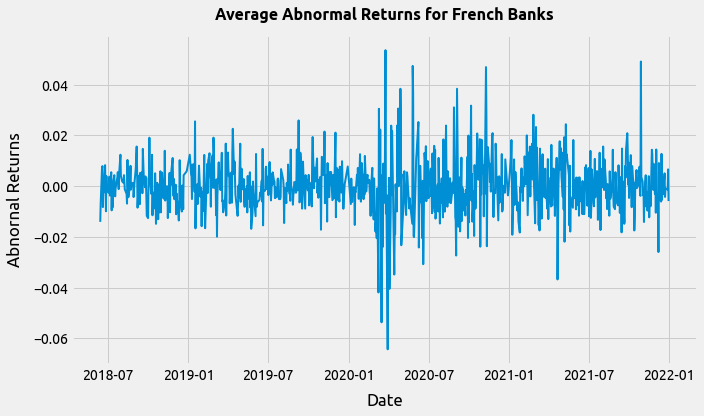

In [29]:
# plot abnormal returns
plt.figure()

plt.title('Average Abnormal Returns for French Banks')
plt.plot(abn_returns['date'], abn_returns['avg_abn_returns'])
plt.ylabel('Abnornal Returns')
plt.xlabel('Date')

plt.show()

### Merge all dataframes

In [17]:
df = pd.merge(df_covid_indicators, df_covid_vaccines, on='date', how='left').fillna(0).iloc[:-1]
df = df.merge(abn_returns[['date', 'avg_abn_returns']], how='left').dropna()
df = df.merge(df_covid_measures_france, how='inner')

## Univariate Data Analysis

### Visualizing raw data 

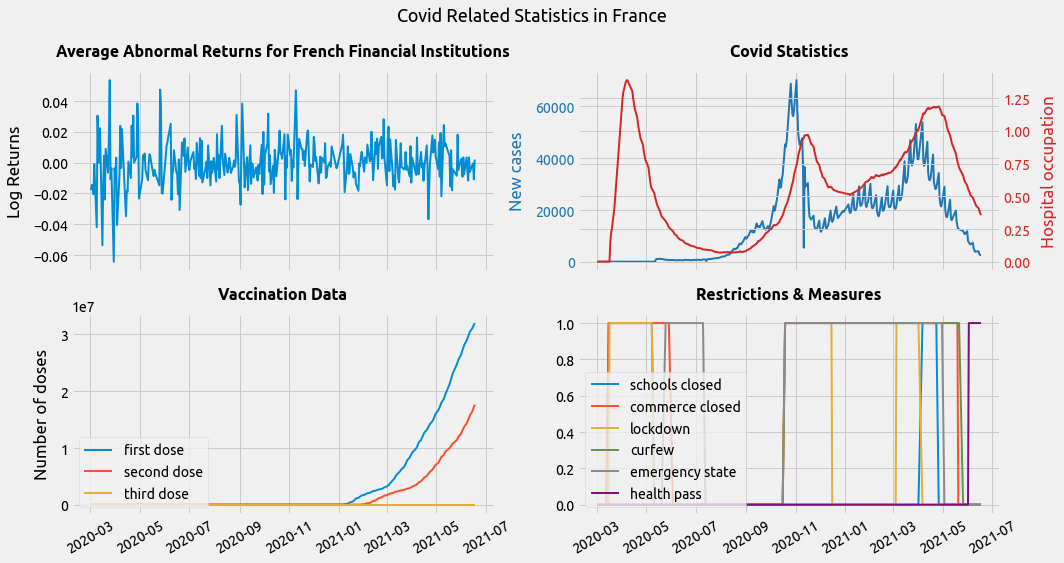

In [73]:
fig, ax = plt.subplots(2,2,sharex=True, figsize=(15,8))

ax[0,0].plot(df['date'], df['avg_abn_returns'])
ax[0,0].set_title('Average Abnormal Returns for French Financial Institutions')
ax[0,0].set_ylabel('Log Returns')

ax[1,0].plot(df['date'], df['n_first_dose'], df['date'], df['n_second_dose'], df['date'], df['n_third_dose'])
ax[1,0].legend(['first dose', 'second dose', 'third dose'], loc='lower left')
ax[1,0].set_title('Vaccination Data')
ax[1,0].set_ylabel('Number of doses')
ax[1,0].tick_params(axis='x', labelrotation = 30)

ax[0,1].plot(df['date'], df['n_cases'], c='tab:blue')
ax2 = ax[0,1].twinx()
ax2.plot(df['date'], df['hosp_occupation_rate'], c='tab:red')
ax[0,1].set_title('Covid Statistics')
ax[0,1].set_ylabel('New cases', color='tab:blue')
ax[0,1].tick_params(axis='y', labelcolor='tab:blue')
ax2.set_ylabel('Hospital occupation', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax[1,1].plot(
    df['date'], df['schools_closed'], 
    df['date'], df['restaurants_museums_closed'],
    df['date'], df['lockdown'],
    df['date'], df['curfew'],
    df['date'], df['emergency'],
    df['date'], df['health_pass']
)
ax[1,1].legend([
    'schools closed',
    'commerce closed',
    'lockdown',
    'curfew',
    'emergency state',
    'health pass'
], loc='lower left')
ax[1,1].set_title('Restrictions & Measures')
ax[1,1].tick_params(axis='x', labelrotation = 30)

fig.suptitle('Covid Related Statistics in France')
plt.tight_layout()
plt.show()

### Analysing correlation between variables

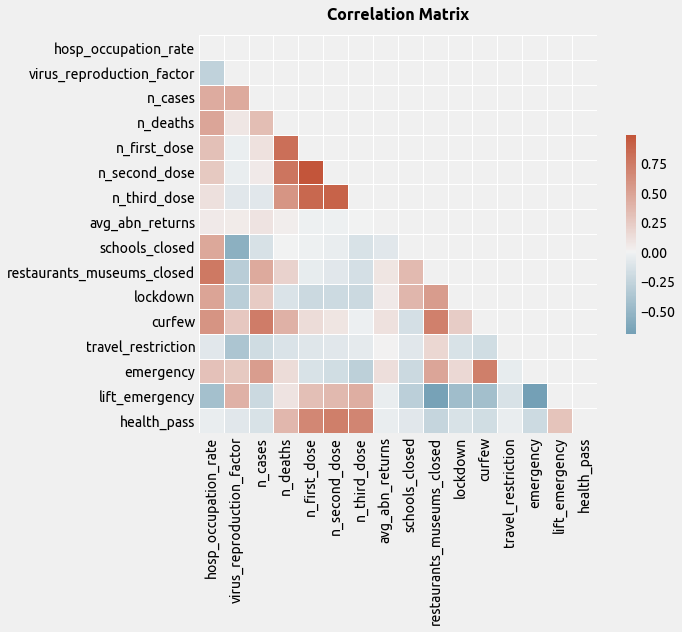

In [83]:
f, ax = plt.subplots(figsize=(11, 9))

corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    center=0,
    square=True,
    linewidths=.5, 
    cbar_kws={"shrink": .5}
    )

plt.title('Correlation Matrix')
plt.show()

## Treating Variables and Performing Tests

### Building variables of interest

Explanatory variables:
- Number of new positive cases (J-3): usually is reported on the news everyday, and it can impact on the prices of stocks (we can also check for the effect of past values)
- Hospital occupation rate: similar to the number of cases.
- Number of new vaccine doses: similar to the ones above.
- Covid related measures: dummy variables indicating the presence of a given restriction

Explained variable:
- Abnormal returns of top french financial stocks.

In [88]:
df['new_vaccines'] = (df['n_first_dose'] + df['n_second_dose'] + df['n_third_dose']).diff()

### Applying an ADF-test to abnormal returns

In [112]:
adf_res = tsa.adfuller(df['avg_abn_returns'], regression='ct', regresults=True)

# Show test results
print(f"T-statistic: {adf_res[0]}")
print(f"P-value: {adf_res[1]}")
print(f"Used lag: {adf_res[3].usedlag}\n")
print(adf_res[3].resols.summary())

T-statistic: -9.796119600292451
P-value: 6.292251857581492e-15
Used lag: 3

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     68.29
Date:                Sat, 01 Jan 2022   Prob (F-statistic):           5.76e-48
Time:                        20:50:28   Log-Likelihood:                 893.02
No. Observations:                 316   AIC:                            -1774.
Df Residuals:                     310   BIC:                            -1752.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

We can see that the test t-stat is low, so we reject the null hypothesis $\rho=0$. For this reason, we conclude that the series is stationary. We can also conclude that the series does not have drift nor trend, because its coefficients are not statistically significant.